## Quantifying Centone Content in Arab Andalusian Music using TF-IDF
March - 2019

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../src/')
sys.path.append('..')

import extraction
import model
import persistence
import reporting

In [3]:
from collections import Counter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import music21

### Load

Load mappings Nawba mappings and recording metadata

In [4]:
data_path = '../data/'

In [5]:
# Nawba Mappings to centones
nawba_centones = persistence.load_and_parse_centones_mapping(os.path.join(data_path, 'Centones_Nawba.csv'))
# Nawba Mappings to tabs
nawba_tabs = persistence.load_and_parse_nawba_tabs(os.path.join(data_path, 'nawba_tabs.json'))

# Recording Descriptions
andalusian_description =  pd.read_json(os.path.join(data_path, 'andalusian_description.json'))

### Download

Download all scores from dunya

In [6]:
dunya_token = '<INSERT_DUNYA_TOKEN_HERE>'
scores_path = os.path.join(data_path, 'scores/')

In [7]:
scores = persistence.download_scores(andalusian_description, dunya_token, target_folder=scores_path)

In [8]:
# Replace tab with nawba
# (mbid, nawba)
mbid_nawba = [[x[0], nawba_tabs[x[1]]] for x in scores if x[1] in nawba_tabs]

# Nawba mbid lookup
nawba_mbid_lookup = {x[0]:x[1] for x in mbid_nawba}

### Pattern Extraction

Load all scores into a stream of notes

In [9]:
def pattern_stream_from_score(path, rest_quarter_length=0):
    """
    Load a score from <path> and return an ordered list of notes
    R represents a rest greater than or equal to <rest_quarter_length>
    ...rests shorter than <rest_quarter_length> are ignored

    Fails if score contains chords
    """

    s = music21.converter.parse(path)
    p = s.parts[0]

    # These are all the notes of the whole piece, fails for chords
    notes_and_rests = p.flat.notesAndRests.stream()
    notes = []
    for n in notes_and_rests:
        if n.isRest:
            if n.duration.quarterLength > rest_quarter_length:
                notes.append('R')
        else:
            notes.append(n.name)
    return notes

In [10]:
notes_dict = {}
chord_mbid = []

for i,(mbid, nawba) in enumerate(mbid_nawba):
    this_score_path = os.path.join(scores_path, mbid + '.xml')
    # Fails for scores with chords
    try:
        note_stream = pattern_stream_from_score(this_score_path)
        notes_dict[mbid] = note_stream
    except Exception as e:
        print('{} contains chords and wont be counted'.format(mbid))
        chord_mbid.append(mbid)

final_scores = [x for x in scores if x[0] not in chord_mbid]

notes_indices = notes_dict.keys()
notes = notes_dict.values()

2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e contains chords and wont be counted


Extract bag of patterns from each score

In [11]:
mbid_patterns = [extraction.extract_pattern_grams(nt, min_n=3, max_n=10) for nt in notes]

In [12]:
# Convert indices from mbid to Nawba
full_nawba_indices = [nawba_mbid_lookup[x] for x in notes_indices]

In [13]:
# Counts of number of scores in each nawba for plotting later
nawba_scores = Counter(full_nawba_indices)

### TFIDF

Apply TF-IDF on corpus of bag of patterns

In [14]:
distributions = model.get_tfidf_distributions(mbid_patterns)

Average tf-idf for each pattern for each Nawba

In [15]:
frame_grouped = model.average_tfidf(distributions, full_nawba_indices)

In [16]:
frame_grouped[:5]

,index,pattern,frequency,tf-idf
0,Nawba_1,,0,0.000000
1,Nawba_1,AAA,1762,0.000411
2,Nawba_1,AAAA,782,0.000189
3,Nawba_1,AAAAA,318,0.000094
4,Nawba_1,AAAAAA,107,0.000032


### Results

Plot analysis results

In [17]:
# Initialise Nawba number to plot
i = 1

Repeatedly run these cells to iterate through all Nawbas

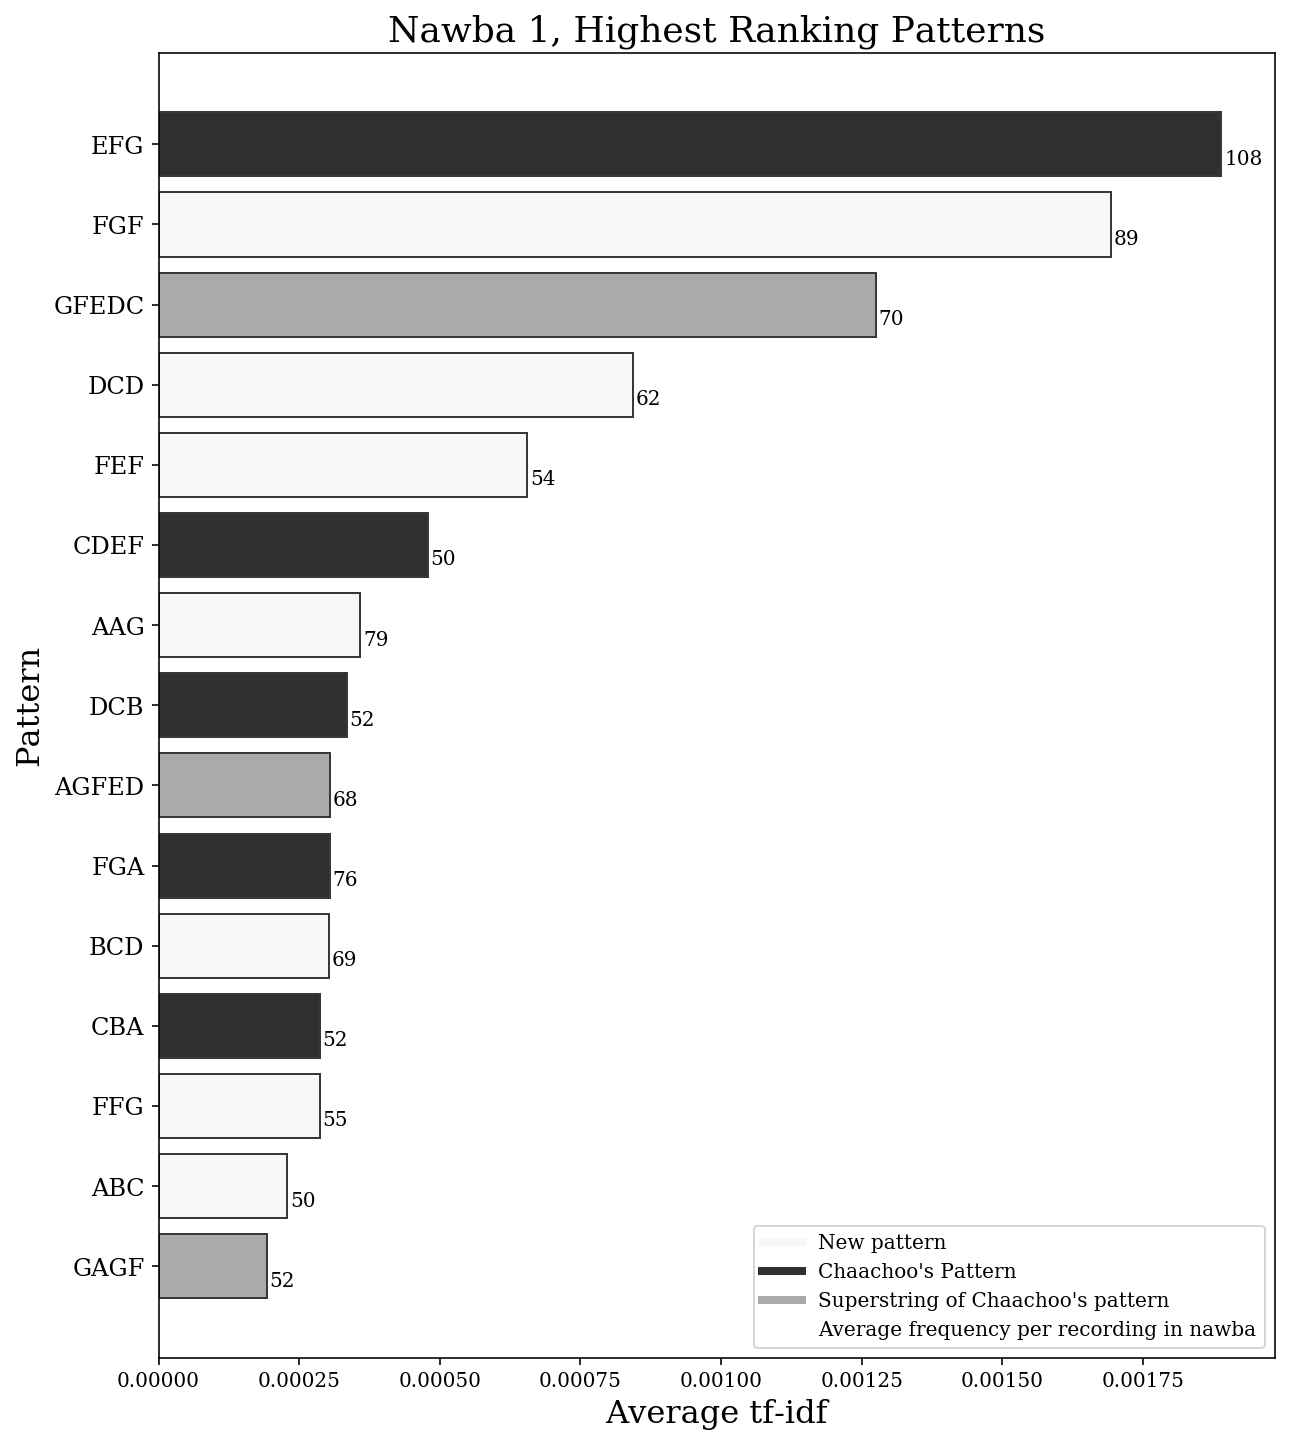

In [19]:
# Bars marked black match amins centones
# Bars marked grey are supersets of amins centones
# Bars marked white are un-defined centones
nawba = 'Nawba_{}'.format(i)
final_patterns = reporting.get_top_centones_plot(frame_grouped, nawba, nawba_centones, nawba_scores[nawba], min_freq=50)
i += 1
if i > len(set(nawba_centones.keys())):
    i = 1

### Classification

In [20]:
from pattern_results import our_centones
import numpy as np

df = model.zip_nawba(distributions, notes_indices)
chaachoo_centones = nawba_centones.copy()

In [21]:
df = model.zip_nawba(distributions, notes_indices)

In [22]:
chaachoo_results = [model.train_classifier(df, chaachoo_centones, mbid_nawba) for x in range(100)]

In [23]:
our_results = [model.train_classifier(df, our_centones, mbid_nawba) for x in range(100)]

In [24]:
print('Our results: {} ({})'.format(round(np.mean(our_results)*100, 2), round(np.std(our_results)*100,2)))

Our results: 72.16 (5.02)


In [25]:
print('Chaachoo results: {} ({})'.format(round(np.mean(chaachoo_results)*100, 2), round(np.std(chaachoo_results)*100,2)))


Chaachoo results: 70.8 (4.88)
